# Standard Cuts Cross-section Analysis 




In [1]:
from sklearn.externals import joblib

In [2]:
run ../prep_ana.py

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Loading plotting specs...
8 or 13 TeV:
Loading 8TeV
unc_mc_process and scales as dictionaries
Load MC and Data?True
Correct MET?True
df = pd.concat([df_dy0, df_dy1, df_dy2, df_dy3, df_dy4, df_dy_m_10, df_ww, df_tt_l, df_tt_sl, df_zz_ln, df_wz_ln, df_wz_lq ])


In [3]:
%matplotlib inline

In [4]:
df_da_a = rp.read_root(data_path+"/muon_2012A_complete.root", columns=columns+["runNum", "eventNumb"])
df_da_b = rp.read_root(data_path+"/muon_2012B_complete.root", columns=columns+["runNum", "eventNumb"])
df_da_c = rp.read_root(data_path+"/muon_2012C_complete.root", columns=columns+["runNum", "eventNumb"])
df_da_d = rp.read_root(data_path+"/muon_2012D_complete.root", columns=columns+["runNum", "eventNumb"])

df_da = pd.concat([df_da_a, df_da_b, df_da_c, df_da_d]).reset_index()

In [5]:
df_da_a_el = rp.read_root(data_path+"/electron_2012A_complete.root", columns=columns+["runNum", "eventNumb"])
df_da_b_el = rp.read_root(data_path+"/electron_2012B_complete.root", columns=columns+["runNum", "eventNumb"])
df_da_c_el = rp.read_root(data_path+"/electron_2012C_complete.root", columns=columns+["runNum", "eventNumb"])
df_da_d_el = rp.read_root(data_path+"/electron_2012D_complete.root", columns=columns+["runNum", "eventNumb"])

df_da_el = pd.concat([df_da_a_el, df_da_b_el, df_da_c_el, df_da_d_el]).reset_index()
df_da = pd.concat( [df_da, df_da_el] ).reset_index()
df_da = df_da.drop(np.where(df_da[["runNum", "eventNumb"]].duplicated())[0])

In [6]:
pre_df = pre_cuts(df, diff_charge=False)
pre_df_da = pre_cuts(df_da, diff_charge=False)

In [7]:
#load random forest
random_forest = joblib.load("../RF/Jan_22_fDY_fTT.jbl")

In [8]:
pred_fTT = random_forest["clf_fTT"].predict_proba(np.float32(pre_df[random_forest["features_fTT"]].values))
pre_df["pred_fTT_WW"] = pred_fTT[:,0]

pred_fDY = random_forest["clf_fDY"].predict_proba(np.float32(pre_df[random_forest["features_fDY"]].values))
pre_df["pred_fDY_WW"] = pred_fDY[:,0]

pred_fTT = random_forest["clf_fTT"].predict_proba(np.float32(pre_df_da[random_forest["features_fTT"]].values))
pre_df_da["pred_fTT_WW"] = pred_fTT[:,0]

pred_fDY = random_forest["clf_fDY"].predict_proba(np.float32(pre_df_da[random_forest["features_fDY"]].values))
pre_df_da["pred_fDY_WW"] = pred_fDY[:,0]

In [ ]:
def rf_ana( df, flavor="both", random_forest=random_forest):
  
  rf_cuts = (df.pred_fTT_WW > .65) & (df.pred_fDY_WW > .972)
  same_cuts = (df.lep_Type < 0) & rf_cuts 
  diff_cuts =  (df.lep_Type > 0) & rf_cuts


  if flavor=="both": return pd.concat( [df[same_cuts], df[diff_cuts]] )
  elif flavor=="same": return df[same_cuts]
  elif flavor=="diff": return df[diff_cuts]

# Yields

In [9]:
df_yields = process_yields(rf_ana(pre_df), rf_ana(pre_df_da))
save_df_to_html(df_yields, "yields_rf.html")

WW 993.712305519 4468.69731269
DY 153.414625395 285.536627108
Top 167.396182615 648.474059429
WZ 35.2774465326 100.182506565
ZZ 33.5176106343 3.6514838434
WG 0.0 141.441088735
Higgs 20.3451732778 69.8640233975
{'Diff Flavor': [4343, 126, 4469, 286, 648, 100, 4, 141, 70, 496, 6214, 6098], 'Same Flavor': [952, 41, 994, 153, 167, 35, 34, 0, 20, 39, 1443, 1524], 'Process': ['WW', 'GluGluToWWTo4L', 'WW', 'DY', 'Top', 'WZ', 'ZZ', 'WG(*)', 'Higgs', 'WJ', 'Total', 'DATA']}


# Plots

(<matplotlib.figure.Figure at 0x259e4cb90>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2581ee250>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x258886bd0>], dtype=object))

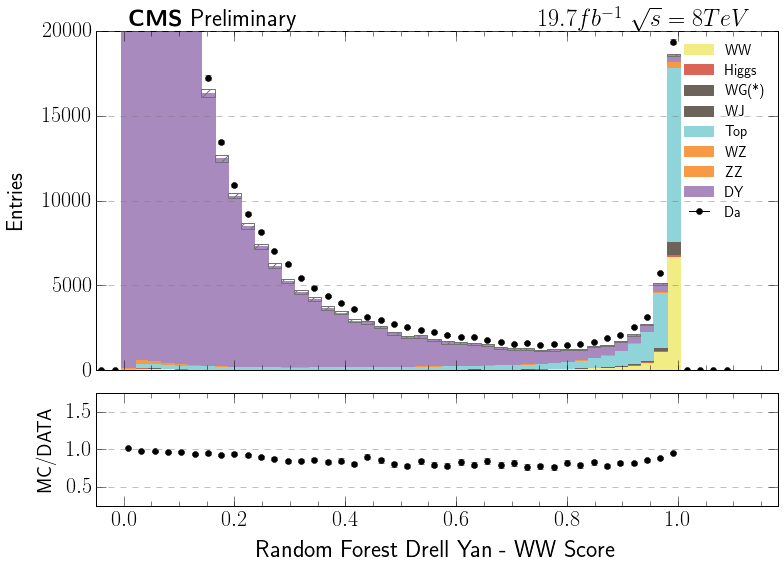

In [17]:
feature = "pred_fDY_WW"
bins_mc = bin_df( pre_df[pre_df.lep1_Charge != pre_df.lep2_Charge], feature, range=(-0.1, 1.1))
bins_data = bin_df( pre_df_da[pre_df_da.lep1_Charge != pre_df_da.lep2_Charge], feature, range=(-0.1, 1.1))

full_plot(bins_mc, bins_data, title="Random Forest Drell Yan - WW Score", color="color_1", x_range=(-0.05, 1.18), logy=False, y_range=(0,20000))

(<matplotlib.figure.Figure at 0x2595d9d90>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x23103bed0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x259e5c250>], dtype=object))

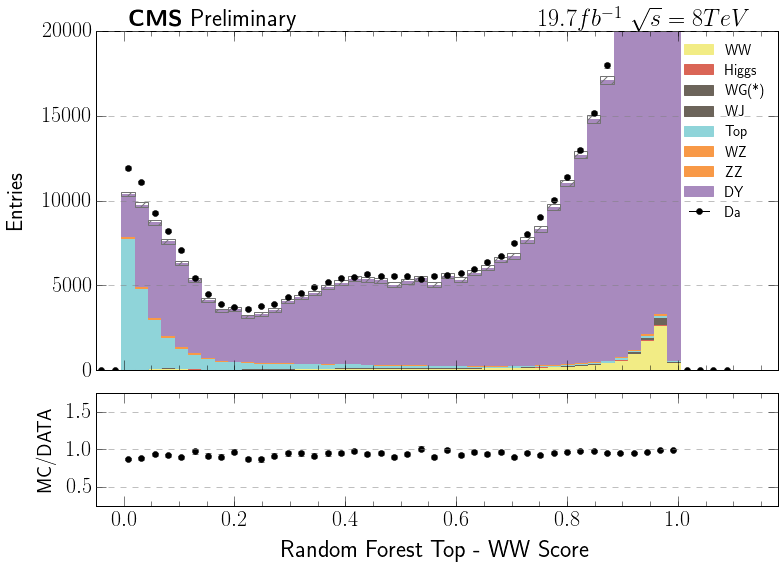

In [16]:
feature = "pred_fTT_WW"
bins_mc = bin_df( pre_df[pre_df.lep1_Charge != pre_df.lep2_Charge], feature, range=(-0.1, 1.1))
bins_data = bin_df( pre_df_da[pre_df_da.lep1_Charge != pre_df_da.lep2_Charge], feature, range=(-0.1, 1.1))

full_plot(bins_mc, bins_data, title="Random Forest Top - WW Score", color="color_1", x_range=(-0.05, 1.18), logy=False, y_range=(0,20000))

(<matplotlib.figure.Figure at 0x2d9d022d0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2daf6ecd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x2dbd43990>], dtype=object))

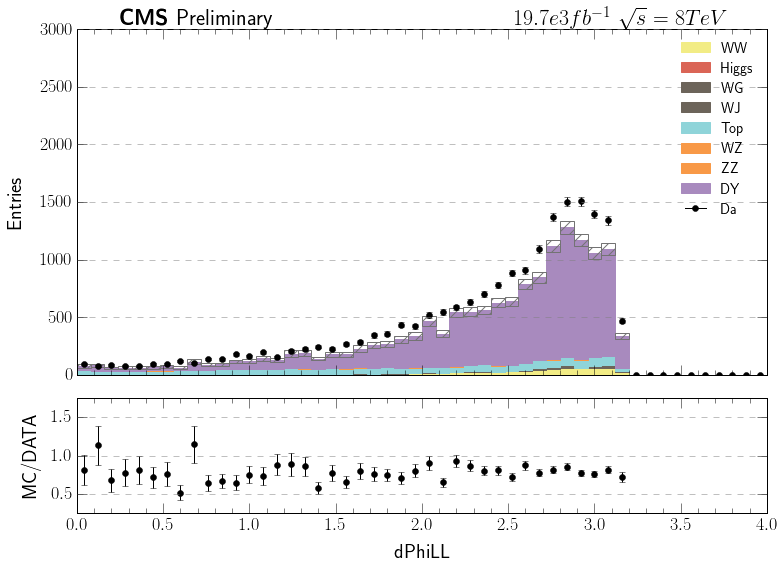

In [18]:
feature = "dPhiLL"
min_ = .5
max_ = .7
bins_mc = bin_df( pre_df[(pre_df.lep1_Charge != pre_df.lep2_Charge) & (pre_df.pred_fDY_WW > min_) & (pre_df.pred_fDY_WW < max_)], feature)
bins_data = bin_df( pre_df_da[(pre_df_da.lep1_Charge != pre_df_da.lep2_Charge) & (pre_df_da.pred_fDY_WW > min_) & (pre_df_da.pred_fDY_WW < max_)], feature)

full_plot(bins_mc, bins_data, color="color_1", logy=False, y_range=(0,3000))

numb_BJet
HT
numb_jets
lep1_pt
jet1_pt
lep2_pt
jet2_pt
metMod
dPhiLL
METProj
qT
dPhiLLJet
met_phi
lep3_pt
tot_npv
mll
METProj_sin
met_over_sET
METProj_trk_sin
recoil
jet1_pt
dPhiLLMET
dPhiMETJet
mllMET


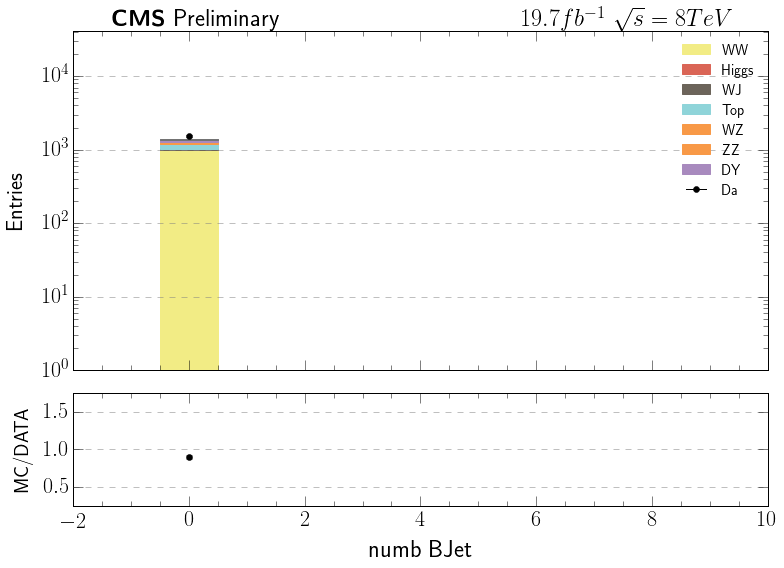

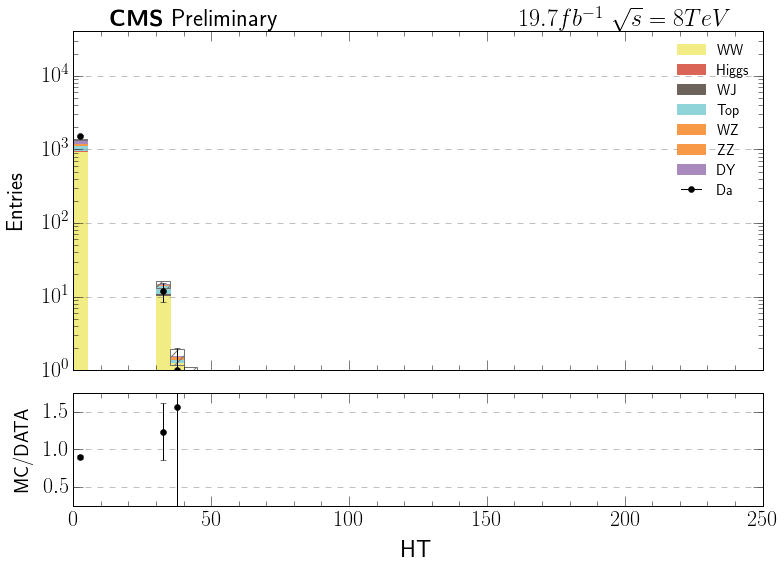

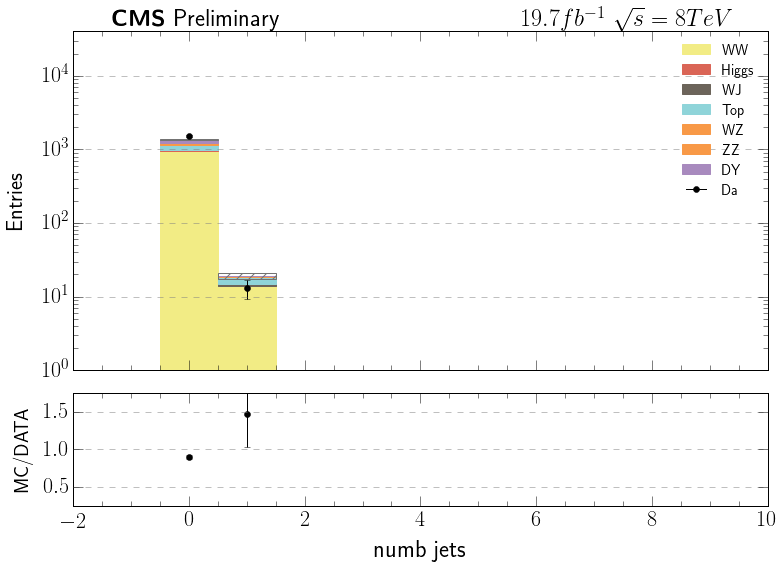

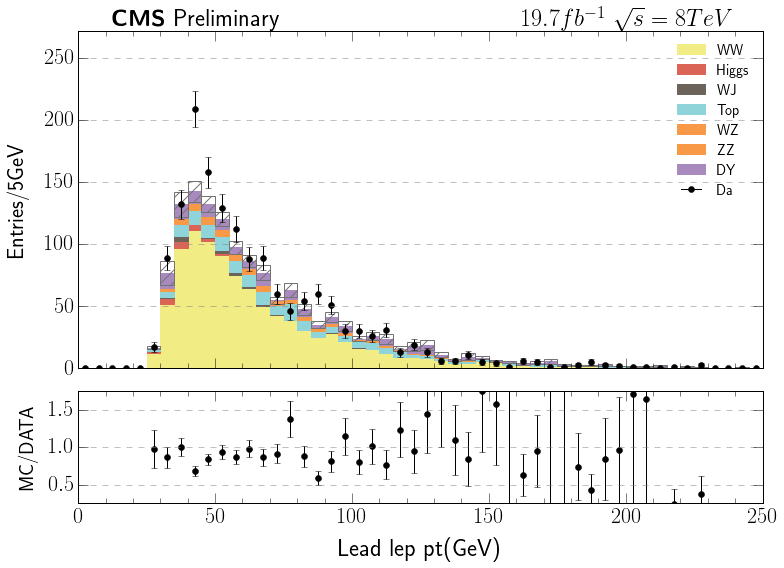

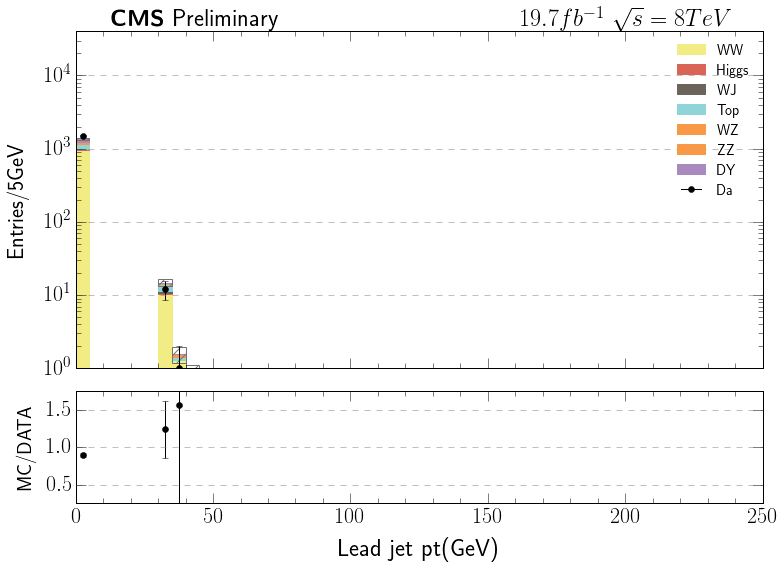

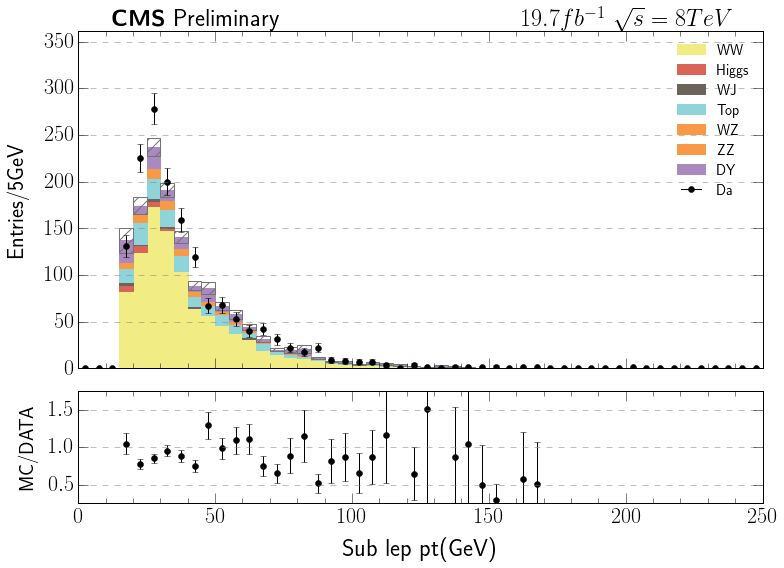

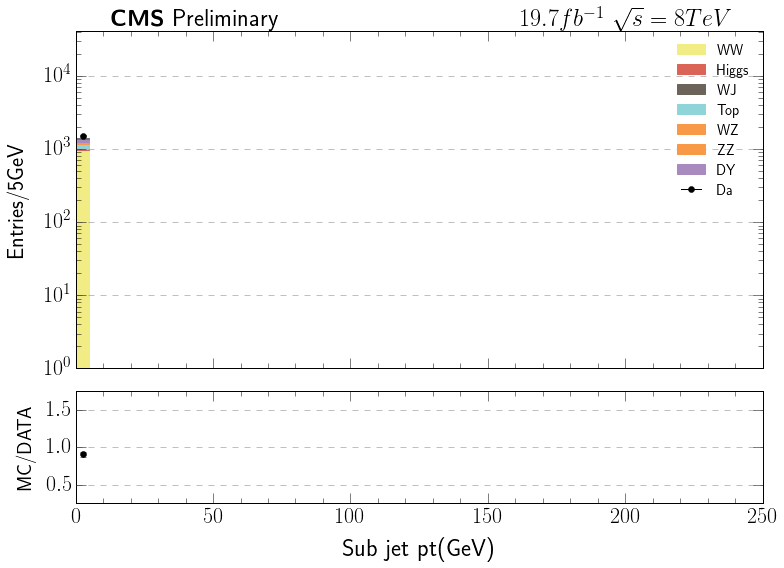

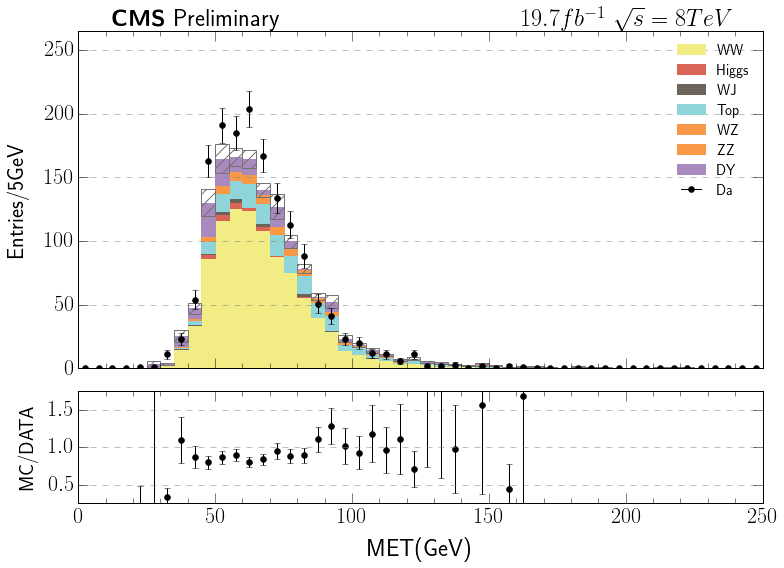

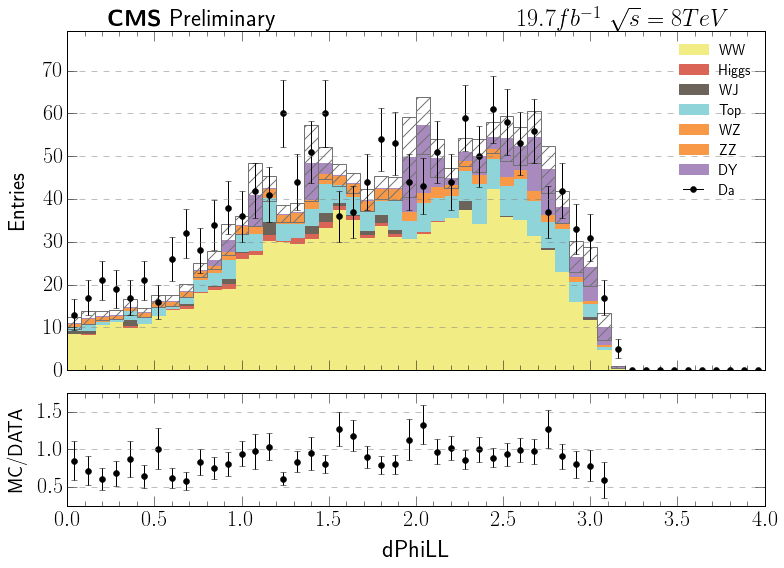

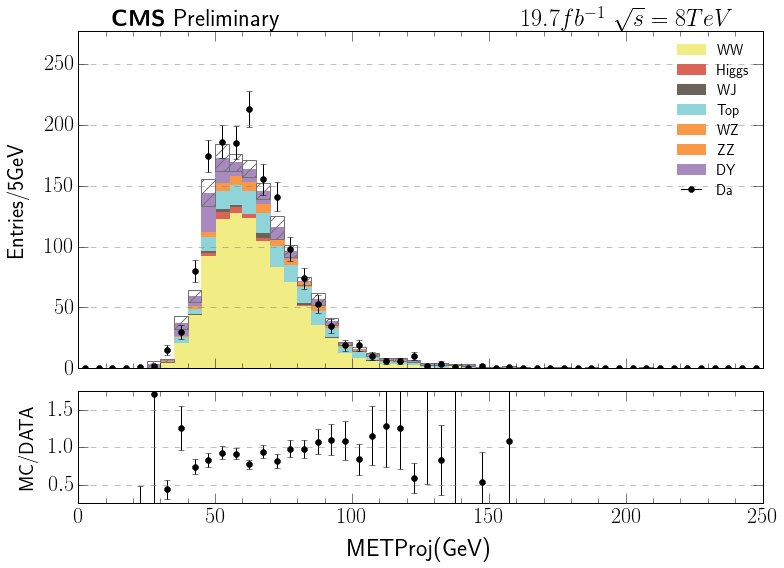

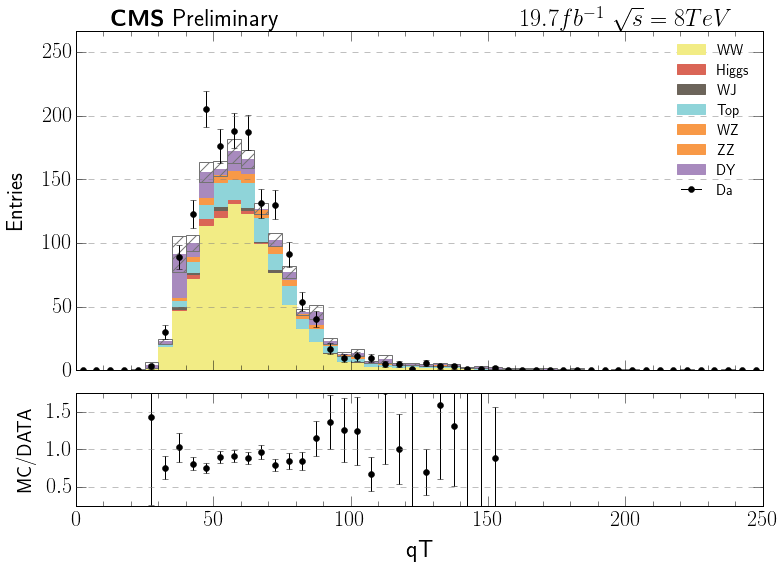

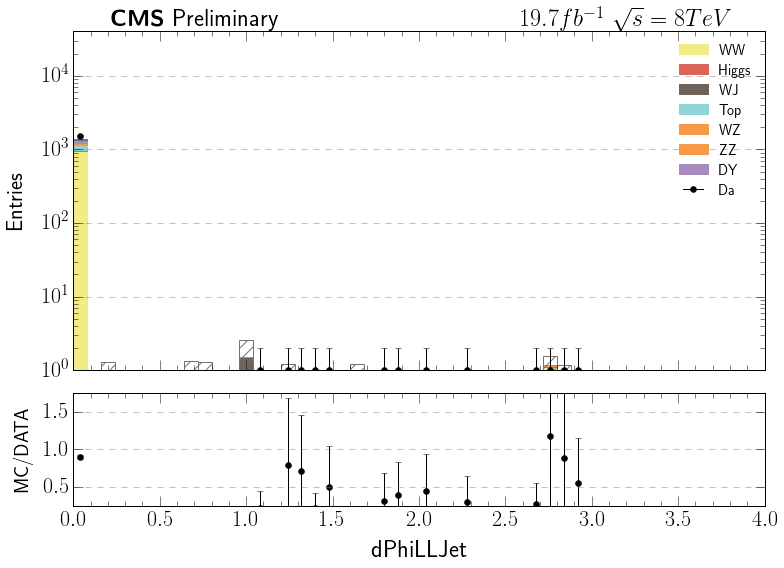

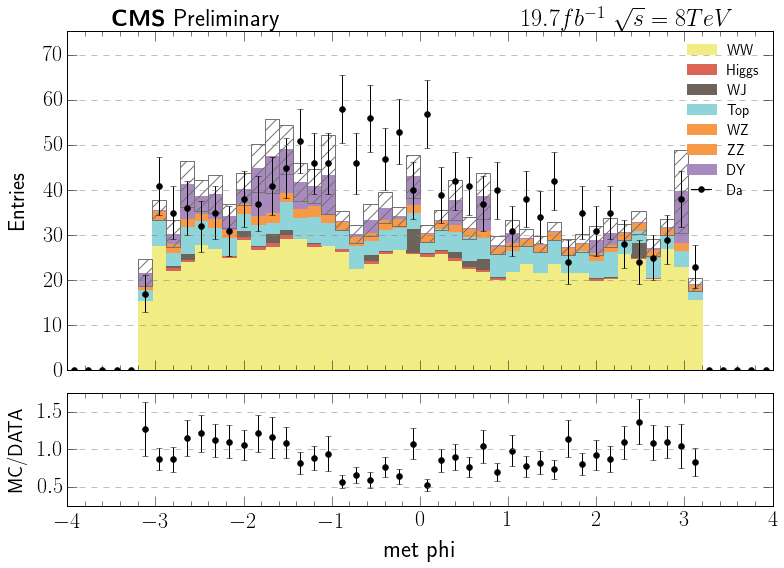

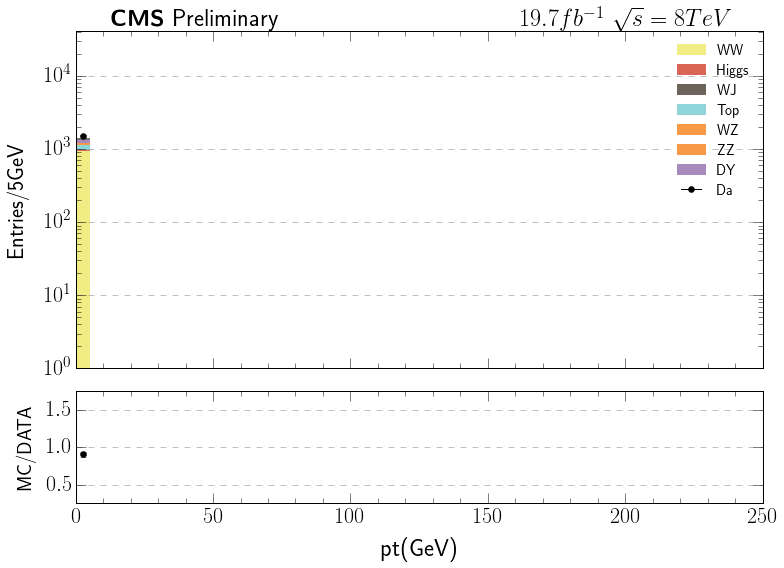

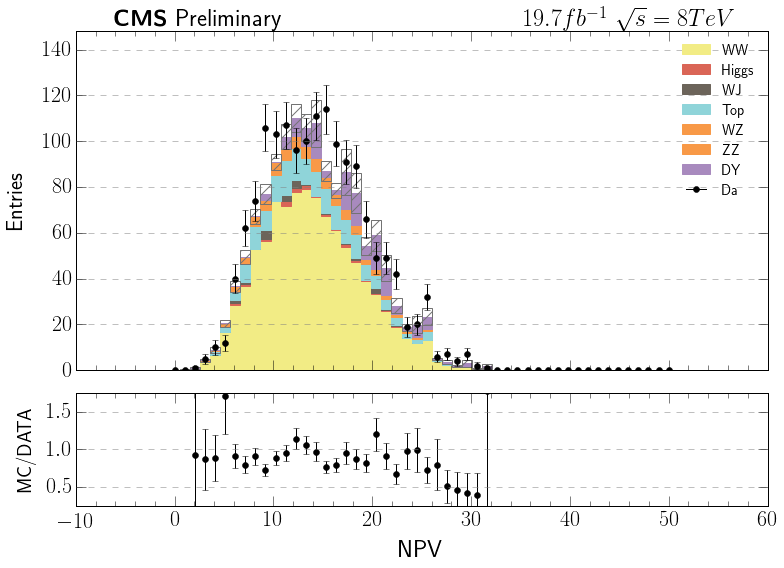

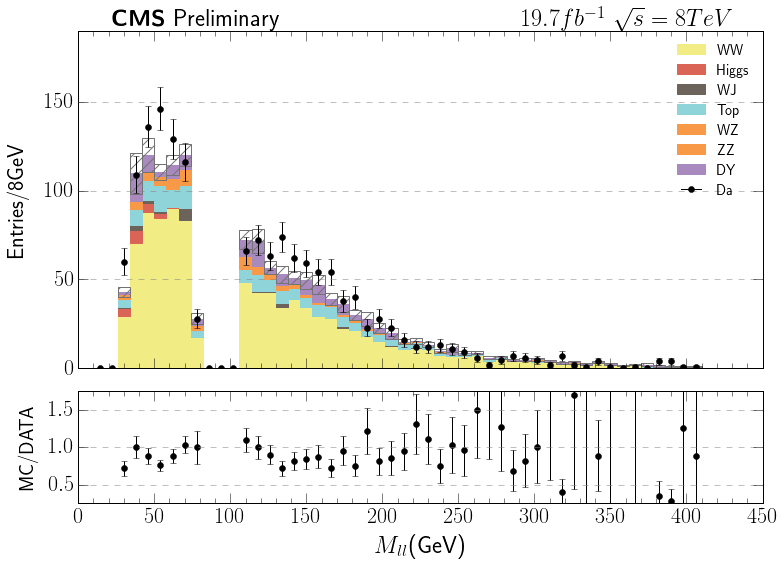

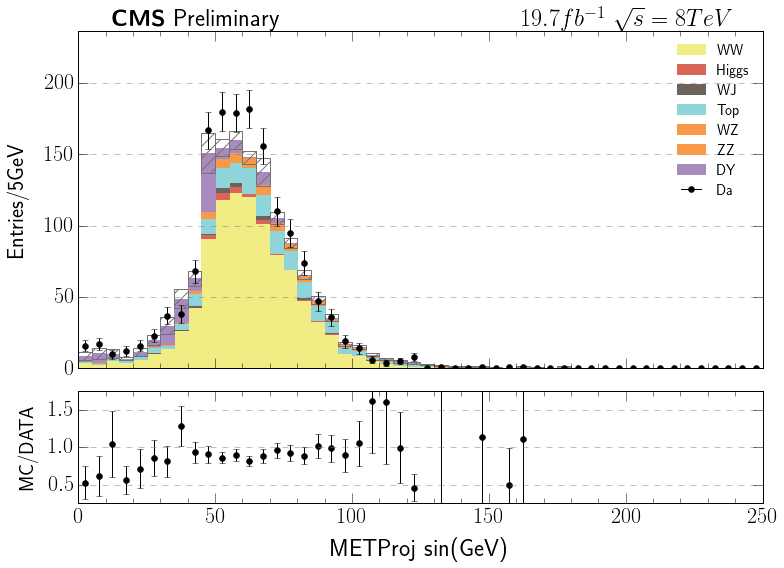

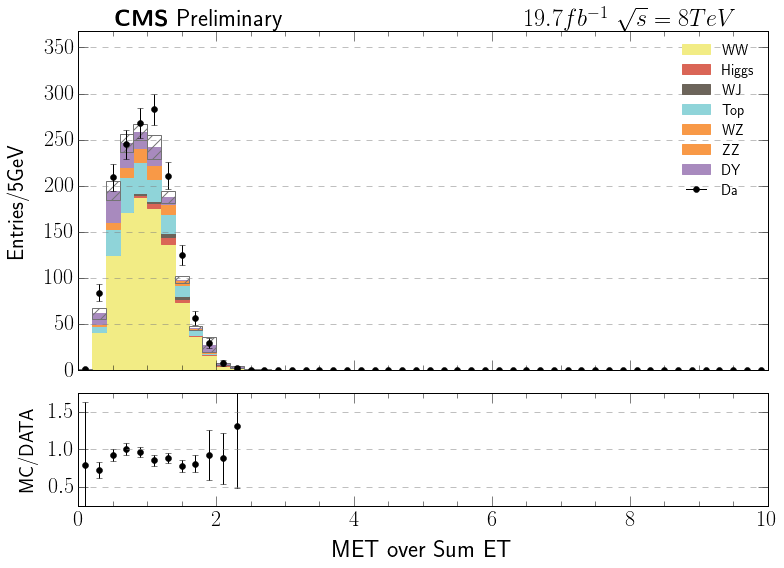

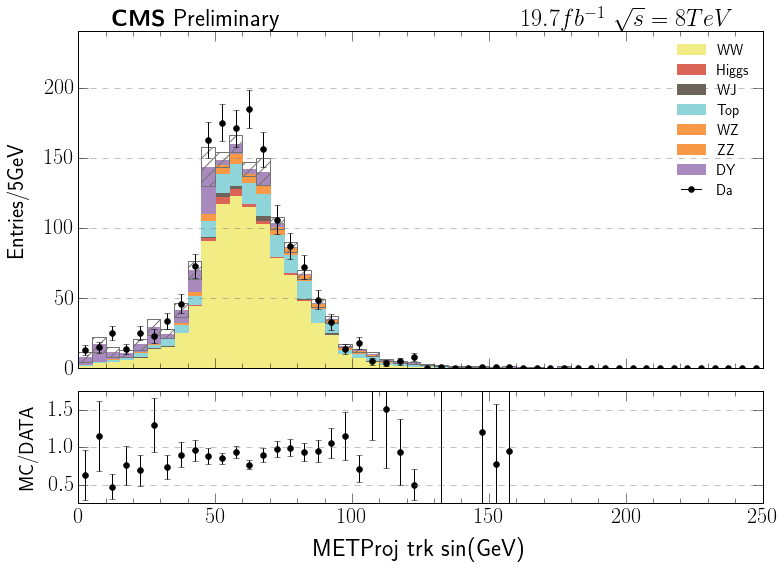

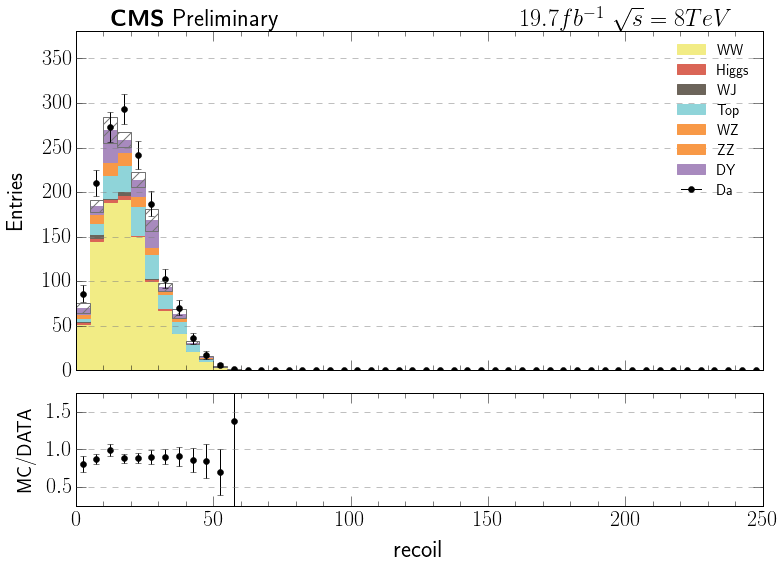

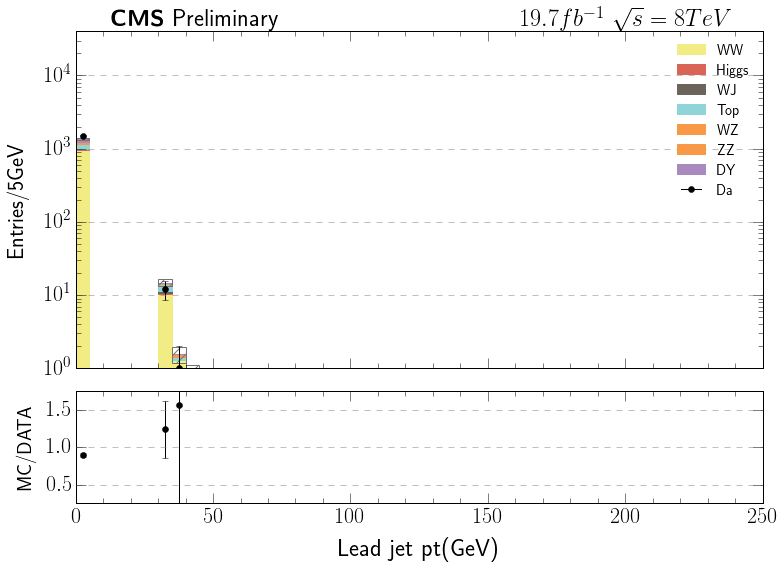

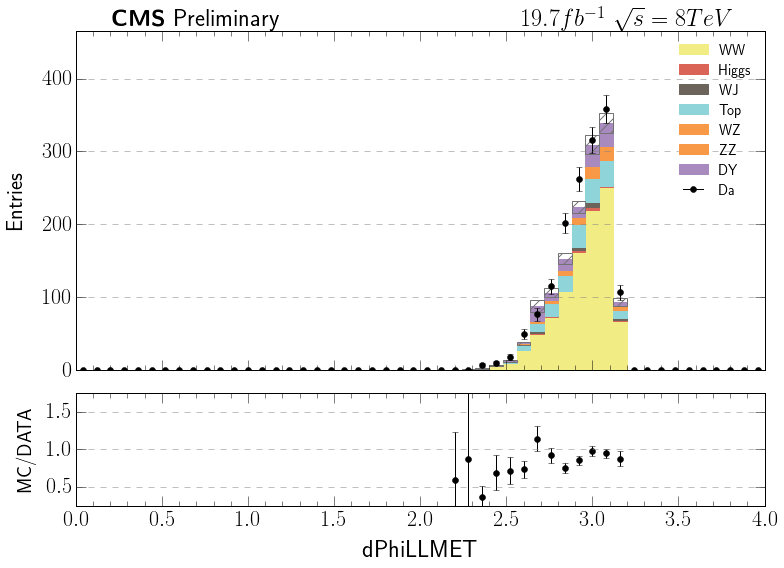

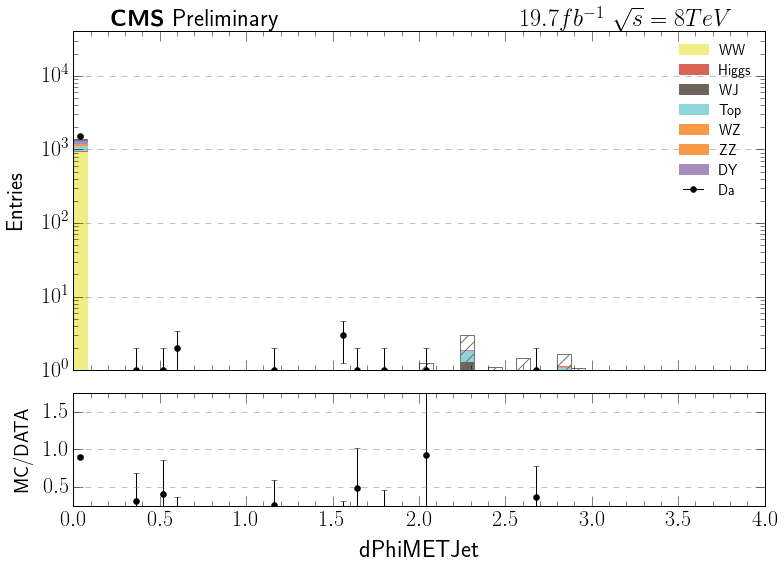

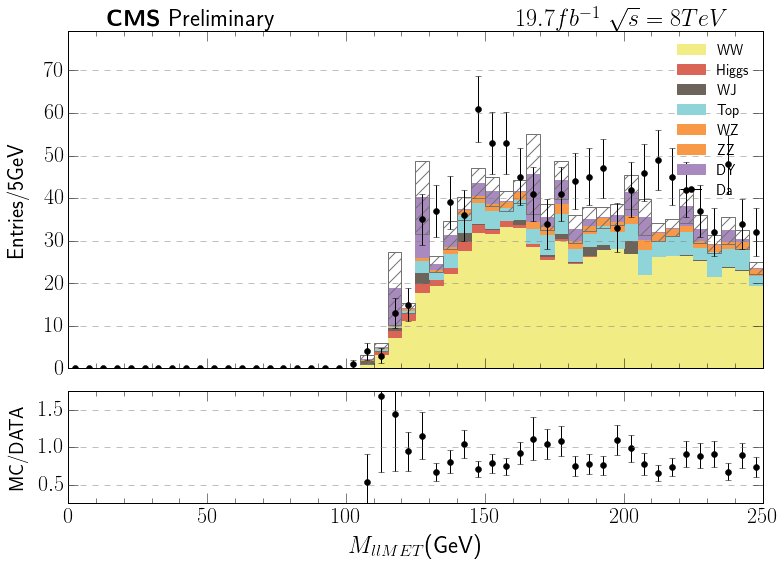

In [14]:
create_kinematic_hist(rf_ana(pre_df, flavor="same"), rf_ana(pre_df_da, flavor="same"), prefix="8TeV/rf_based/cuts_rf_same")

# Cross section calc

In [12]:
def calc_cross_stuff(df_mc, df_data, flavor="both", ):
    lumi = 19.7e3
    eff  = .1247 #this had to be changed previously
    Br   = (3*.108)**2. 
    
    df_mc_c = df_mc[df_mc.lep1_Charge != df_mc.lep2_Charge]
    df_data_c = df_data[df_data.lep1_Charge != df_data.lep2_Charge]
    
    df_mc_c_s = df_mc[df_mc.lep1_Charge == df_mc.lep2_Charge]
    df_data_c_s = df_data[df_data.lep1_Charge == df_data.lep2_Charge]
    
    N_mc = sum([ rf_ana(df_mc_c[df_mc_c.process_decay == process], flavor=flavor).weight.values.sum()*scales[process] for process in scales.keys() if process not in ['WW', 'W1JetsToLNu','W2JetsToLNu','W3JetsToLNu','W3JetsToLNu'] ])
    N_Wjets = rf_ana(df_data_c_s, flavor=flavor).shape[0] -  np.array([ rf_ana(df_mc_c_s[(df_mc_c_s.process_decay == process) ], flavor=flavor).weight.values.sum()*scales[process] for process in scales.keys() if process not in [ 'W1JetsToLNu','W2JetsToLNu','W3JetsToLNu','W3JetsToLNu'] ]).sum()
    N_mc += N_Wjets
    
    N_data = rf_ana(df_data_c, flavor=flavor).shape[0]
    
    N_ww_select = rf_ana(df_mc_c[df_mc_c.process_decay == "WW"], flavor=flavor).weight.values.sum()*scales["WW"] +\
                rf_ana(df_mc_c[df_mc_c.process_decay == "GluGluToWWTo4L"], flavor=flavor).weight.values.sum()*scales["GluGluToWWTo4L"]
    N_ww_tot = df_ww.weight.values.sum()*scales["WW"] + df_ggWW.weight.values.sum()*scales["GluGluToWWTo4L"]

    ratio_s_t = N_ww_select / N_ww_tot
    #print "MC", N_mc
    #print "DATA", N_data
    #print N_ww_select / N_ww_tot
    #print "WJ", N_Wjets
    return {"lumi": lumi, "eff": eff, "Br": Br, "N_mc": N_mc, "N_data": N_data, "ratio_s_t": ratio_s_t, "N_ww_select":N_ww_select, "N_Wjets": N_Wjets}

In [13]:
def stat_unc_calc(df_mc, df_data, flavor="both", fiducial=False, **kwargs):
    if kwargs:
        var = kwargs
    else:
        var = calc_cross_stuff(df_mc, df_data, flavor)
    lumi = var["lumi"]
    eff = var["eff"]
    Br = var["Br"]
    N_mc = var["N_mc"]
    N_data = var["N_data"]
    ratio_s_t = var["ratio_s_t"]
    N_ww_select = var["N_ww_select"]
    N_Wjets = var["N_Wjets"]
    
    cuts_mc = {process: rf_ana(df_mc[(df_mc.process_decay == process) & (df_mc.lep1_Charge != df_mc.lep2_Charge)], flavor) for process in scales.keys()} 
    process_stat_unc = [ (cuts_mc[process].weight.values * cuts_mc[process].weight.values).sum()  * scales[process]**2 for process in cuts_mc.keys() if process not in ['WW', 'W1JetsToLNu','W2JetsToLNu','W3JetsToLNu','W3JetsToLNu']] 
    
    WW_stat_unc = (cuts_mc["WW"].weight.values * cuts_mc["WW"].weight.values).sum() * scales["WW"]**2. * ratio_s_t**2. / N_ww_select**2.
    
    #print "Process stat", process_stat_unc
    #print "WW stat",WW_stat_unc
    if fiducial == False:
        return 1. / (lumi * eff * Br * ratio_s_t) * ( N_data + sum(process_stat_unc) + WW_stat_unc + N_Wjets)**.5
    else:
        return 1. / (lumi * eff ) * ( N_data + sum(process_stat_unc) + N_Wjets)**.5

In [22]:
def sys_unc_calc(df_mc, df_data, flavor="both", fiducial=False, **kwargs):
    if kwargs:
        var = kwargs
    else:
        var = calc_cross_stuff(df_mc, df_data, flavor)
    lumi = var["lumi"]
    eff = var["eff"]
    Br = var["Br"]
    N_mc = var["N_mc"]
    N_data = var["N_data"]
    ratio_s_t = var["ratio_s_t"]
    N_ww_select = var["N_ww_select"]
    N_Wjets = var["N_Wjets"]
    
    cuts_mc = {process: rf_ana(df_mc[(df_mc.process_decay == process) & (df_mc.lep1_Charge != df_mc.lep2_Charge)], flavor) for process in scales.keys()} 
    process_sys_unc = [ scales[process]**2. * unc_mc_process[process]**2 * cuts_mc[process].shape[0]**2. for process in cuts_mc.keys() if process not in ['WW', 'W1JetsToLNu','W2JetsToLNu','W3JetsToLNu','W3JetsToLNu']] 

    #print process_sys_unc
    WW_sys_unc = unc_mc_process["WW"]**2 * ratio_s_t**2. / N_ww_select**2.
    Wjets_sys_unc = N_Wjets**2. 
    
    if fiducial == False:
        return 1. / (lumi * eff * Br * ratio_s_t)  * ( sum(process_sys_unc) +  WW_sys_unc + Wjets_sys_unc)**.5
    else:
        return 1. / (lumi * eff )  * ( sum(process_sys_unc) + Wjets_sys_unc)**.5

In [15]:
def cross_calc(df_mc, df_data, flavor="both", fiducial=False, **kwargs):
    if kwargs:
        var = kwargs
    else:
        var = calc_cross_stuff(df_mc, df_data, flavor)
    lumi = var["lumi"]
    eff = var["eff"]
    Br = var["Br"]
    N_mc = var["N_mc"]
    N_data = var["N_data"]
    ratio_s_t = var["ratio_s_t"]
    N_ww_select = var["N_ww_select"]
    N_Wjets = var["N_Wjets"]
    
    if fiducial == False:
        return  (N_data - N_mc) / (lumi * eff * Br *ratio_s_t)
    else:
        return (N_data - N_mc) / (lumi * eff ) 

In [23]:
full = {}

flavor = 'both'
kwds = calc_cross_stuff(pre_df, pre_df_da, flavor)
full['both'] = [ cross_calc(pre_df, pre_df_da, flavor=flavor, **kwds), stat_unc_calc(pre_df, pre_df_da, flavor, **kwds), sys_unc_calc(pre_df, pre_df_da, flavor, **kwds)]
print full['both']

flavor = 'same'
kwds = calc_cross_stuff(pre_df, pre_df_da, flavor)
full['same'] = [cross_calc(pre_df, pre_df_da, flavor=flavor, **kwds), stat_unc_calc(pre_df, pre_df_da, flavor, **kwds), sys_unc_calc(pre_df, pre_df_da, flavor, **kwds)]
print full['same']

flavor = 'diff'
kwds = calc_cross_stuff(pre_df, pre_df_da, flavor)
full['diff'] = [ cross_calc(pre_df, pre_df_da, flavor=flavor, **kwds), stat_unc_calc(pre_df, pre_df_da, flavor, **kwds), sys_unc_calc(pre_df, pre_df_da, flavor, **kwds)]
print full['diff']

[56.218732644126852, 0.98105938808710957, 2.1819511979846595]
[59.96879872354102, 2.4790707231417093, 0.7129977508617259]
[55.383433117752531, 1.0649321098853255, 2.5391720895970029]


In [63]:
fiducial = {}

flavor = 'both'
kwds = calc_cross_stuff(pre_df, pre_df_da, flavor)
fiducial['both'] = [ cross_calc(pre_df, pre_df_da, flavor=flavor, fiducial=True, **kwds), stat_unc_calc(pre_df, pre_df_da, flavor, fiducial=True, **kwds), sys_unc_calc(pre_df, pre_df_da, flavor, fiducial=True, **kwds)]
print flavor, fiducial['both']

flavor = 'same'
kwds = calc_cross_stuff(pre_df, pre_df_da, flavor)
fiducial['same'] = [cross_calc(pre_df, pre_df_da, flavor=flavor, fiducial=True, **kwds), stat_unc_calc(pre_df, pre_df_da, flavor, fiducial=True, **kwds), sys_unc_calc(pre_df, pre_df_da, flavor, fiducial=True, **kwds)]
print flavor, fiducial['same']

flavor = 'diff'
kwds = calc_cross_stuff(pre_df, pre_df_da, flavor)
fiducial['diff'] = [ cross_calc(pre_df, pre_df_da, flavor=flavor, fiducial=True, **kwds), stat_unc_calc(pre_df, pre_df_da, flavor, fiducial=True, **kwds), sys_unc_calc(pre_df, pre_df_da, flavor, fiducial=True, **kwds)]
print flavor, fiducial['diff']

both [2.2814586828971413, 0.036851774685863814, 0.087945279608963381]
same [0.44485759142756504, 0.01600993926059904, 0.004820073376566549]
diff [1.8366011276065632, 0.033192395836801232, 0.083267254001844287]


# Make Cross Section tables

In [21]:
from html import HTML

In [22]:
def make_cross_table(cross_dic):
    html_bot = HTML('html', 'text')
    t = html_bot.table( border="0", border_="collapse")
    key_syn = {"both": "Together", "same": "Same", "diff": "Different"}
    for key in cross_dic:
        r = t.tr
        for i, ele in enumerate(cross_dic[key]):
            prefix = ""
            postfix = ""
            if i == 0: r.td.b(key_syn[key]+":" , border="none")
            else: 
                prefix = "&plusmn;"
                if i == 1: postfix = "(stat)"
                if i == 2: postfix = "(sys)"
            r.td(prefix + str(round(ele, 2)) + postfix, border="none", escape=False)
    print t

In [24]:
make_cross_table(full)

<table border="0" border_="collapse">
<tr><td><b border="none">Together:</b></td><td border="none">56.22</td><td border="none">&plusmn;0.91(stat)</td><td border="none">&plusmn;2.16(sys)</td></tr>
<tr><td><b border="none">Same:</b></td><td border="none">59.97</td><td border="none">&plusmn;2.17(stat)</td><td border="none">&plusmn;0.55(sys)</td></tr>
<tr><td><b border="none">Different:</b></td><td border="none">55.38</td><td border="none">&plusmn;1.0(stat)</td><td border="none">&plusmn;2.52(sys)</td></tr>
</table>


# How to pick a barafasdf asdhfandf asdf

In [ ]:
two_tree_process_map(df)

In [22]:
abc.hist(pre_df[pre_df.process == "WW"].numb_jets.values, weights=pre_df[pre_df.process == "WW"].weight.values)

# Probing the Jet region

(<matplotlib.figure.Figure at 0x23b4cad10>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x238785610>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x238bcbb10>], dtype=object))

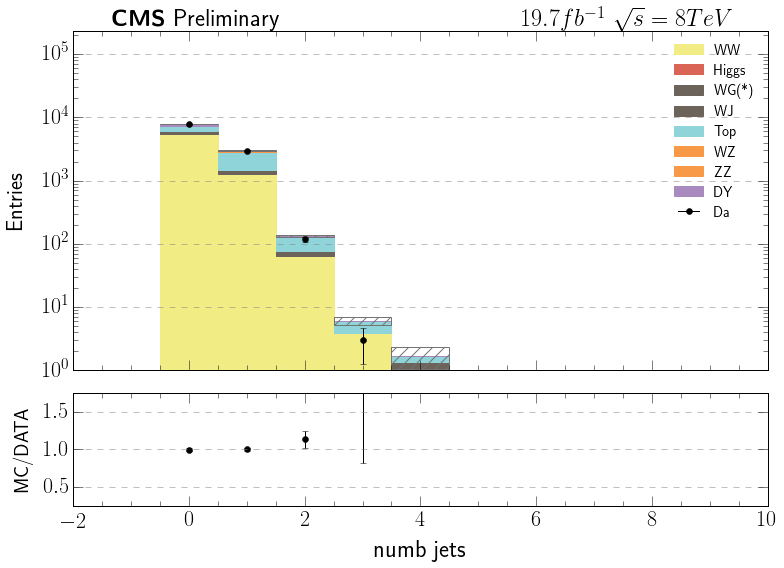

In [44]:
feature = "numb_jets"
TT_cut = .27
bins_mc = bin_df( pre_df[(pre_df.lep1_Charge != pre_df.lep2_Charge) & (pre_df.pred_fDY_WW > .972) & (pre_df.pred_fTT_WW > TT_cut) ], feature)
bins_data = bin_df( pre_df_da[(pre_df_da.lep1_Charge != pre_df_da.lep2_Charge) & (pre_df_da.pred_fDY_WW > .972) & (pre_df_da.pred_fTT_WW > TT_cut) ], feature)

full_plot(bins_mc, bins_data, color="color_1",)

In [45]:
bins_mc

{'DYJetsToLL_M-10to50': [array([ 25.34588242,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ], dtype=float32),
  array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
  array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
  array([ 198.71089172,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ], dtype=float32)],
 'DYJetsToLL_M-50': [array([ 347.99160767,   98.17205048,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ], dtype=float32),
  array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
  array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
  array([ 868.78503418,  259.14019775,    0.        ,    0.        ,
            0.        ,    0.        ,  

# lep, met, jet scale uncertainties

In [48]:
def scale_shift(data, lep_pt=1.01, met=1.02, jet=1.02 ):
    data.lep1_pt = data.lep1_pt * lep_pt
    data.lep2_pt = data.lep2_pt * lep_pt
    data.mll = data.mll * lep_pt**.5
    
    
    data.metMod = data.metMod * met
    data.metProj = data.METProj * met
    
    data.mllMET = data.mllMET * met * lep_pt**.5
    
    
    data.HT = data.HT * jet

In [56]:
scale_shift(df_da)

In [45]:
#a = df_da.metMod
df_da.metMod = df_da.metMod * 1.02

In [44]:
df_da.mll = df_da.mll * 1.02

In [8]:
two_tree_map =two_tree_process_map( pre_df, ["pred_fTT_WW", "pred_fDY_WW"], bins=50)
two_tree_yield = yield_asymetry( two_tree_map, pre_df )

DYJetsToLL_M-50
DYJetsToLL_M-10to50
WW
ttbar_leptonic
ttbar_semileptonic
Tbar_s-channel
Tbar_t-channel
Tbar_tW-channel
T_s-channel
T_t-channel
T_tW-channel
ZZJetsTo2L2Q
ZZJetsTo2L2Nu
WZJetsTo3LNu
WZJetsTo2L2Q
WGToLNuG
W1JetsToLNu
W2JetsToLNu
W3JetsToLNu
W4JetsToLNu
GluGluToHToWWTo2LAndTau2Nu
WGstarToLNu2E
GluGluToWWTo4L


NameError: name 'test' is not defined

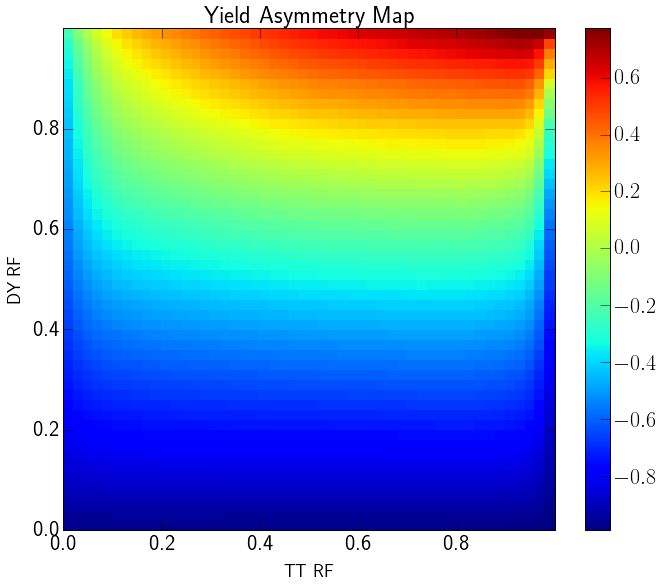

In [21]:
fig, ax = plt.subplots(figsize=(11,9))
yield_map = ax.pcolor(two_tree_yield[0])#[35:,10:])
plt.colorbar(yield_map)
plt.xticks([i for i in range( len(two_tree_yield[1][0])) if i%10==0], [i for e, i in enumerate(two_tree_yield[1][0]) if e%10==0])
plt.yticks([i for i in range( len(two_tree_yield[1][1])) if i%10==0], [i for e, i in enumerate(two_tree_yield[1][1]) if e%10==0])
plt.xlabel("TT RF")
plt.ylabel("DY RF")
plt.title("Yield Asymmetry Map")


In [14]:
def calc_stat_unc( data ):
    coeff = 1./(19.4e3*.15*(3*.108)**2*(data["WW"] /  np.max(data["WW"])))
    norm = [ scales[process]*(data[process]/scales[process])**0.5 for process in data.keys() if "WW" not in process]
    
    sum_norm = np.zeros(data[process].shape)
    for ele in norm:
        sum_norm += ele**2 
    return coeff*(sum_norm + scales["WW"]/data["WW"] )**.5

In [15]:
def full_stat( data ):
    coeff = 1./(19.7e3*.15*(3*.108)**2*(data["WW"] /  np.max(data["WW"])))
    stat = np.zeros(data["WW"].shape)
    for i in data.keys():
        stat += data[i]
        
    return coeff*(stat)**.5

In [16]:
def calc_norm_unc( data ):
    coeff = 1./(19.4e3*.15*(3*.108)**2*(data["WW"] /  np.max(data["WW"])))
    norm = [ unc_mc_process[process]*(data[process])**0.5 for process in data.keys() if "WW" not in process]
    sum_norm = np.zeros(data[process].shape)
    for ele in norm:
        sum_norm += ele**2
    return coeff*(sum_norm + unc_mc_process["WW"]/data["WW"])**.5

In [17]:
def unc_map( process_map ):

    ax_i = process_map[1][0]
    ax_j = process_map[1][1]
    
    unc_sum = np.power(calc_norm_unc( process_map[0] )**2 + calc_stat_unc( process_map[0] )**2,.5 )#+ full_stat( process_map[0] )**2,.5)
    print unc_sum.min()
    unc_sum = unc_sum / unc_sum.min()
    return unc_sum, [ax_i,ax_j]

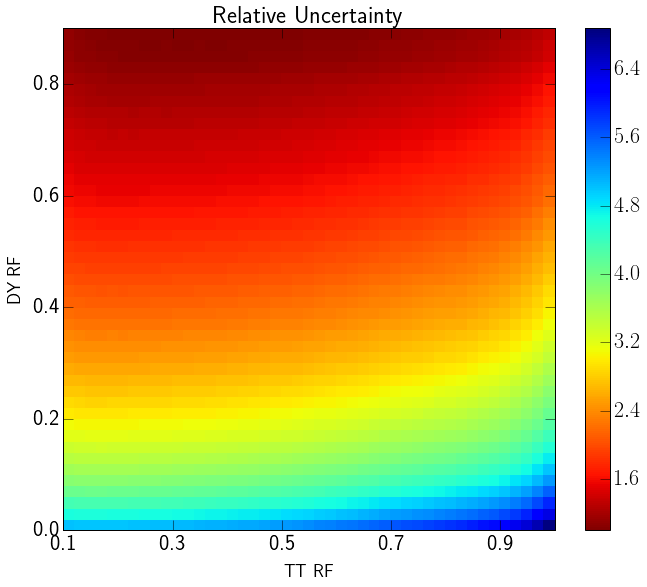

In [38]:
#two_tree_unc =  unc_map(two_tree_map)
fig, ax = plt.subplots(figsize=(11,9))
x = 5
y = 45
b = ax.pcolor(two_tree_unc[0][x:,:y], cmap=matplotlib.cm.jet_r )#5:,:45
plt.colorbar(b, )#cmap=matplotlib.cm.jet_r)
plt.xticks([i for i in range( len(two_tree_unc[1][0][x:])) if i%10==0], [i for e, i in enumerate(two_tree_unc[1][0][x:]) if e%10==0])
plt.yticks([i for i in range( len(two_tree_unc[1][1][:y])) if i%10==0], [i for e, i in enumerate(two_tree_unc[1][1][:y]) if e%10==0])
plt.xlabel("TT RF")
plt.ylabel("DY RF")
plt.title("Relative Uncertainty")

In [36]:
two_tree_unc[1][0][x:]

array([ 0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,  0.22,  0.24,  0.26,
        0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,  0.4 ,  0.42,  0.44,
        0.46,  0.48,  0.5 ,  0.52,  0.54,  0.56,  0.58,  0.6 ,  0.62,
        0.64,  0.66,  0.68,  0.7 ,  0.72,  0.74,  0.76,  0.78,  0.8 ,
        0.82,  0.84,  0.86,  0.88,  0.9 ,  0.92,  0.94,  0.96,  0.98])

In [35]:
two_tree_unc[1][1][:y]

array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
        0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
        0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
        0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
        0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88])

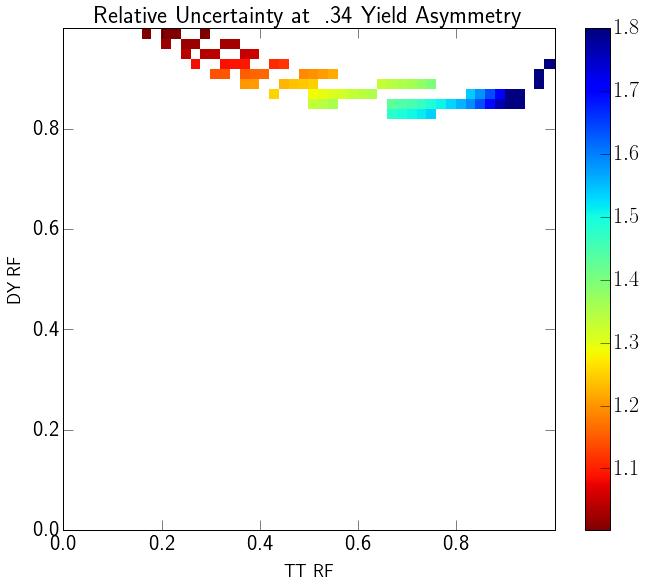

In [46]:
yield_selection = np.where( (two_tree_yield[0] > .326) & (two_tree_yield[0] < .366))

unc_copy = np.copy(two_tree_unc[0])

cut_1 = (two_tree_yield[0] < .326) | (two_tree_yield[0] > .366)
cut_2 = (two_tree_yield[0] < .28) | (two_tree_yield[0] > .3)
cut_3 = (two_tree_yield[0] < .4) | (two_tree_yield[0] > .43)

unc_copy[ cut_1 & cut_2 & cut_3 ] = np.nan

fig, ax = plt.subplots(figsize=(11,9))
cmap = matplotlib.cm.jet_r
cmap.set_bad('white', 1.)



masked_array = np.ma.array (unc_copy, mask=np.isnan(unc_copy))

f_bar = ax.pcolormesh(masked_array, cmap=cmap, vmax=1.8)


plt.xticks([i for i in range( len(two_tree_yield[1][0])) if i%10==0], [i for e, i in enumerate(two_tree_yield[1][0]) if e%10==0])
plt.yticks([i for i in range( len(two_tree_yield[1][1])) if i%10==0], [i for e, i in enumerate(two_tree_yield[1][1]) if e%10==0])
plt.xlabel("TT RF")
plt.ylabel("DY RF")
plt.colorbar(f_bar)
plt.title("Relative Uncertainty at ~.34 Yield Asymmetry")

In [28]:
pre_df[pre_df.process == "WW"].shape

(154392, 33)

In [36]:
abc.legend?

(array([  1.16403389e+04,   4.11955029e+03,   9.74806396e+02,
          2.02877090e+02,   3.52326164e+01,   5.64596748e+00,
          1.43888867e+00,   2.45719522e-01,   0.00000000e+00,
          0.00000000e+00]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
 <a list of 1 Patch objects>)

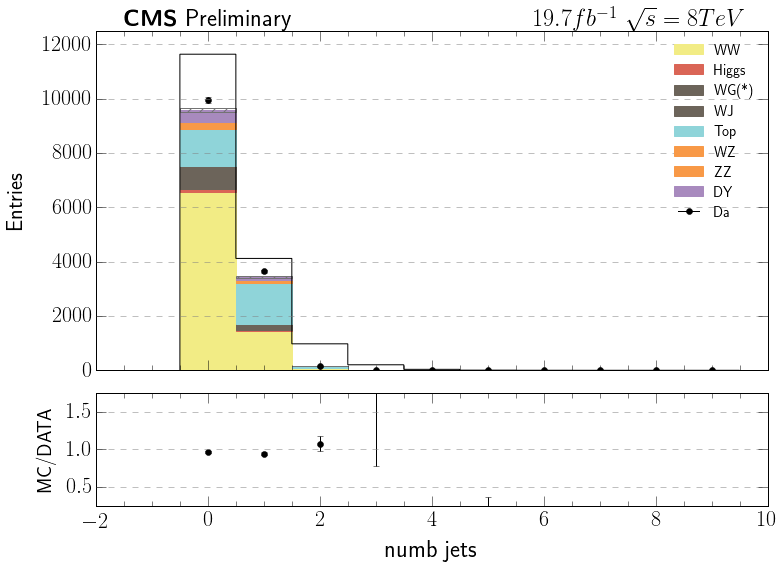

In [10]:
feature = "numb_jets"
TT_cut = .27
bins_mc = bin_df( pre_df[(pre_df.lep1_Charge != pre_df.lep2_Charge) & (pre_df.pred_fDY_WW > .972) & (pre_df.pred_fTT_WW > TT_cut) ], feature)
bins_data = bin_df( pre_df_da[(pre_df_da.lep1_Charge != pre_df_da.lep2_Charge) & (pre_df_da.pred_fDY_WW > .972) & (pre_df_da.pred_fTT_WW > TT_cut) ], feature)

fig, ax = full_plot(bins_mc, bins_data, color="color_1", logy=False, y_range=(0,12500) )
ax[0].hist(pre_df[pre_df.process == "WW"].numb_jets.values, weights=pre_df[pre_df.process == "WW"].weight.values * scales["WW"], range=(-.5, 9.5), histtype=u'step', color="black", label="MC WW")


In [64]:
rf_mc = bin_df( pre_df[(pre_df.lep1_Charge != pre_df.lep2_Charge) & (pre_df.pred_fDY_WW > .972) & (pre_df.pred_fTT_WW > TT_cut) ], feature)
mc = bin_df( pre_df[(pre_df.lep1_Charge != pre_df.lep2_Charge)  ], feature)

rf_mc["WW"][0] / mc["WW"][0]

array([ 0.60427678,  0.38717392,  0.07885415,  0.02033088,  0.01454312,
        0.        ,  0.        ,  0.        ,         nan,         nan], dtype=float32)

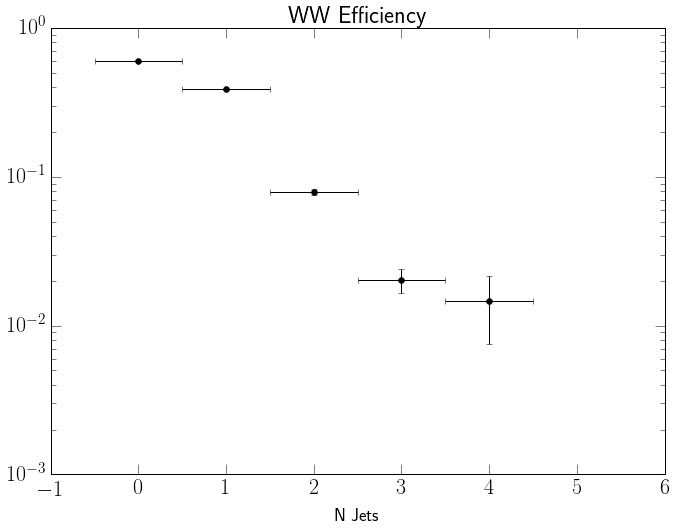

In [86]:
rf_over_mc = rf_mc["WW"][0] / mc["WW"][0]
y_err = rf_over_mc* np.sqrt( rf_mc["WW"][3] / rf_mc["WW"][0]**2. +  mc["WW"][3] / mc["WW"][0]**2.  )

plt.figure(figsize=(11,8))
plt.errorbar( y= rf_over_mc, x= mc["WW"][2], yerr=y_err, xerr=.5, ecolor='black',color="black",fmt="o", )
plt.yscale("log")
plt.xlim((-1, 6))
plt.title("WW Efficiency")
plt.xlabel("N Jets")

In [73]:
y_err

array([ 0.00341626,  0.00433351,  0.00354511,  0.0038128 ,  0.00706351,
               nan,         nan,         nan,         nan,         nan], dtype=float32)

In [74]:
rf_mc["WW"][3] / rf_mc["WW"][0]**2.

array([  1.99238402e-05,   9.03102773e-05,   1.87305815e-03,
         3.44799086e-02,   2.32137099e-01,              nan,
                    nan,              nan,              nan,
                    nan], dtype=float32)